In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
books = pd.read_csv('books.csv')

# Preprocessing

In [3]:
books.describe()

,id,book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


Kita akan menghapus kolom-kolom yang tidak diperlukan untuk analisis kita, seperti isbn, isbn13, image_url, dan small_image_url.

In [4]:
books.drop(['isbn', 'isbn13', 'image_url', 'small_image_url','id','book_id','best_book_id','work_id'], axis=1, inplace=True)


In [5]:
books = books.dropna()

Agar lebih mudah dalam membaca data, kita akan mengubah nama kolom book_id menjadi id, num_pages menjadi pages, dan average_rating menjadi rating.

In [6]:
books.rename(columns={ 'average_rating': 'rating'}, inplace=True)


Setelah melihat informasi tentang dataset kita, kita melihat bahwa kolom language_code memiliki nilai yang hilang. Kita dapat mengisi nilai yang hilang tersebut dengan nilai unknown.

In [7]:
books['language_code'].fillna('unknown', inplace=True)


Beberapa kolom membutuhkan pengubahan tipe data agar sesuai dengan jenis data yang sesuai. Kolom id perlu diubah menjadi tipe data int, kolom authors perlu diubah menjadi tipe data str, dan kolom publication_date perlu diubah menjadi tipe data datetime.

In [9]:
books['authors'] = books['authors'].astype('str')


Kita perlu memeriksa apakah ada duplikat dalam dataset kita menggunakan fungsi duplicated(). Jika ada duplikat, kita dapat menghapusnya menggunakan fungsi drop_duplicates().

In [10]:
print(books.duplicated().sum()) # Cek apakah ada duplikat
books.drop_duplicates(inplace=True) # Menghapus duplikat


0


# Feature Engineering

Kita dapat mengekstrak genre dari kolom title menggunakan regex. Kita dapat menggunakan modul re untuk melakukan hal ini.

In [11]:
genre_list = ['Mystery', 'Romance', 'Fiction', 'Fantasy', 'Nonfiction', 'Children', 'Horror', 'Thriller', 'Young Adult', 'Biography', 'Historical', 'Comics']

def extract_genre(text):
    for genre in genre_list:
        if re.search(genre, text, re.IGNORECASE):
            return genre
    return 'Other'

books['genre'] = books['title'].apply(extract_genre)

Kita dapat menambahkan kolom author_count untuk menghitung jumlah penulis pada setiap buku.

In [12]:
books['author_count'] = books['authors'].apply(lambda x: len(x.split(',')))


# EDA

Mencari jumlah buku

In [13]:
print(f"Jumlah buku: {books.shape[0]}")

Jumlah buku: 8405


Menghitung jumlah penulis buku dalam dataset yang disediakan

In [14]:
authors = books['authors'].str.split(',').explode().str.strip().unique()
print(f"Jumlah penulis unik: {len(authors)}")

Jumlah penulis unik: 5043


Mengetahui genre populer dari buku

Other         8308
Children        39
Biography       17
Mystery         11
Romance          9
Fiction          9
Horror           3
Comics           3
Fantasy          3
Thriller         2
Historical       1
Name: genre, dtype: int64


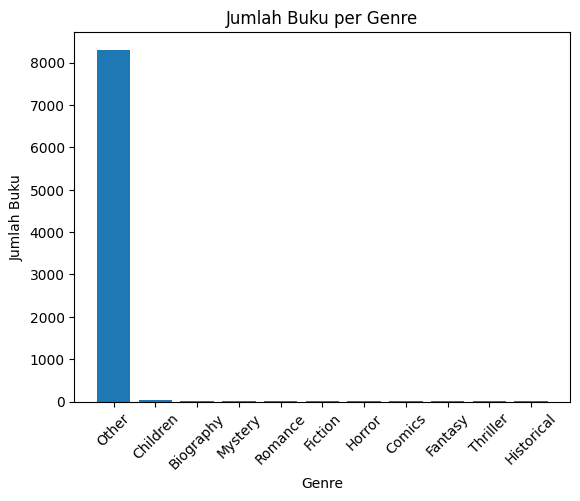

In [15]:
genre_counts = books['genre'].value_counts()
print(genre_counts)

plt.bar(genre_counts.index, genre_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.ylabel('Jumlah Buku')
plt.title('Jumlah Buku per Genre')
plt.show()

Mencari tahu distribusi penerbitan buku

-1750.0      1
-762.0       1
-750.0       2
-720.0       1
-560.0       1
          ... 
 2013.0    424
 2014.0    381
 2015.0    244
 2016.0    170
 2017.0      9
Name: original_publication_year, Length: 276, dtype: int64


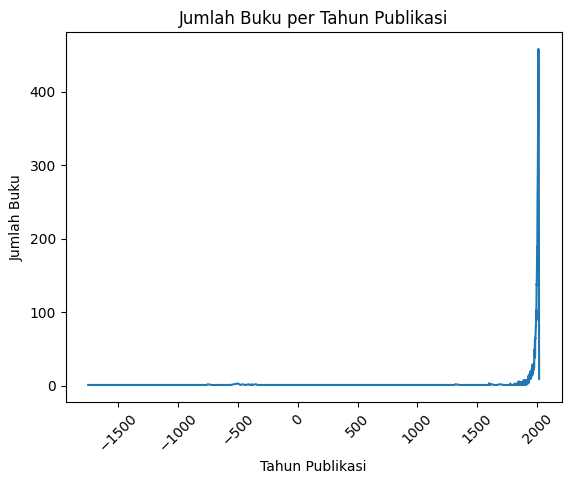

In [16]:
year_counts = books['original_publication_year'].value_counts().sort_index()
print(year_counts)

plt.plot(year_counts.index, year_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Tahun Publikasi')
plt.ylabel('Jumlah Buku')
plt.title('Jumlah Buku per Tahun Publikasi')
plt.show()

Mengetahui distribusi penulis dengan jumlah buku yang diterbitkan

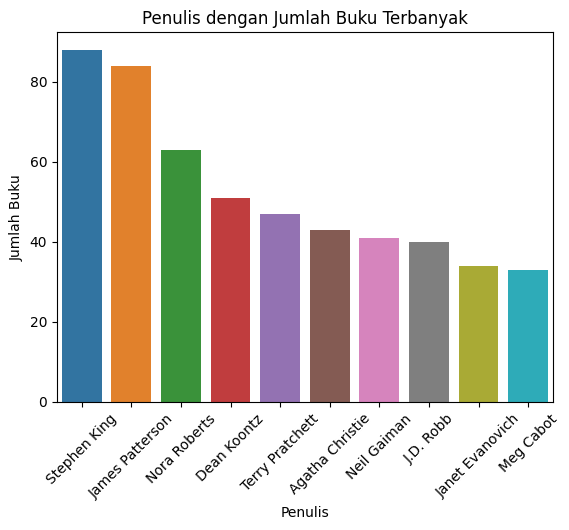

In [17]:
author_counts = books['authors'].str.split(',').explode().str.strip().value_counts().head(10)

sns.barplot(x=author_counts.index, y=author_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Penulis')
plt.ylabel('Jumlah Buku')
plt.title('Penulis dengan Jumlah Buku Terbanyak')
plt.show()

Mengetahui distribusi rating buku

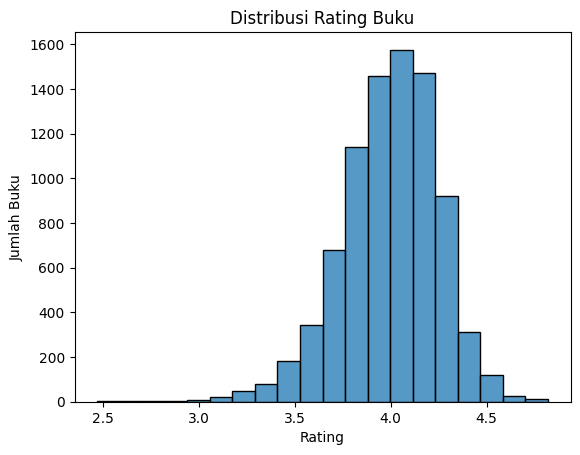

In [18]:
sns.histplot(x='rating', data=books, bins=20)
plt.xlabel('Rating')
plt.ylabel('Jumlah Buku')
plt.title('Distribusi Rating Buku')
plt.show()

Mengetahui distribusi bahasa

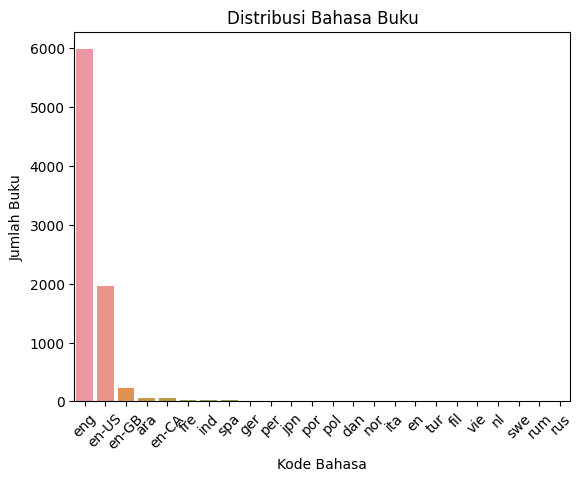

In [19]:
language_counts = books['language_code'].value_counts()

sns.barplot(x=language_counts.index, y=language_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Kode Bahasa')
plt.ylabel('Jumlah Buku')
plt.title('Distribusi Bahasa Buku')
plt.show()

# Book Recommender

In [21]:
#Buat fungsi untuk mendapatkan index dari buku berdasarkan judul dan penulisnya
def get_book_index(title, author):
    index = books[(books['title'] == title) & (books['authors'] == author)].index.tolist()
    if len(index) == 0:
        return -1
    else:
        return index

In [22]:
#Buat fungsi untuk melakukan prediksi buku jika buku yang diinput tidak ditemukan di dalam dataset
def predict_book(title, author):
    # Membuat vektor TF-IDF untuk setiap buku
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(books['title'].astype(str) + " " + books['authors'].astype(str))
    # Mencari buku yang paling mirip dengan buku yang diinput
    query = tfidf_vectorizer.transform([title + " " + author])
    cosine_similarities = cosine_similarity(query, tfidf).flatten()
    related_docs_indices = cosine_similarities.argsort()[:-2:-1]
    index = related_docs_indices[0]
    return index


In [23]:
'''
User menginputkan 3 buku kesukaannya dan pengarangnya, lalu kode akan melakukan prediksi index
dari setiap buku tersebut
'''
book1_title = input("Masukkan judul buku pertama yang disukai: ")
book1_author = input("Masukkan nama pengarang buku pertama yang disukai: ")
book1_index = get_book_index(book1_title, book1_author)
if book1_index == -1:
    book1_index = predict_book(book1_title, book1_author)

books.iloc[book1_index]

Masukkan judul buku pertama yang disukai: Sapiens
Masukkan nama pengarang buku pertama yang disukai: Harari


books_count                                                    109
authors                                          Yuval Noah Harari
original_publication_year                                   2011.0
original_title                              קיצור תולדות האנושות‎‎
title                        Sapiens: A Brief History of Humankind
language_code                                                  eng
rating                                                        4.41
ratings_count                                                52846
work_ratings_count                                           71074
work_text_reviews_count                                       6685
ratings_1                                                      996
ratings_2                                                     1627
ratings_3                                                     6468
ratings_4                                                    19971
ratings_5                                                    4

In [24]:
book2_title = input("Masukkan judul buku kedua yang disukai: ")
book2_author = input("Masukkan nama pengarang buku kedua yang disukai: ")
book2_index = get_book_index(book2_title, book2_author)
if book2_index == -1:
    book2_index = predict_book(book2_title, book2_author)

books.iloc[book2_index]


Masukkan judul buku kedua yang disukai: Cosmos
Masukkan nama pengarang buku kedua yang disukai: Sagan


books_count                          93
authors                      Carl Sagan
original_publication_year        1980.0
original_title                   Cosmos
title                            Cosmos
language_code                       eng
rating                             4.35
ratings_count                     76440
work_ratings_count                81022
work_text_reviews_count            1833
ratings_1                          1403
ratings_2                          2044
ratings_3                          8926
ratings_4                         22885
ratings_5                         45764
genre                             Other
author_count                          1
Name: 1234, dtype: object

In [25]:
book3_title = input("Masukkan judul buku ketiga yang disukai: ")
book3_author = input("Masukkan nama pengarang buku ketiga yang disukai: ")
book3_index = get_book_index(book3_title, book3_author)
if book3_index == -1:
    book3_index = predict_book(book3_title, book3_author)

books.iloc[book3_index]


Masukkan judul buku ketiga yang disukai: Genome
Masukkan nama pengarang buku ketiga yang disukai: Riddley


books_count                                                                 44
authors                                                            Matt Ridley
original_publication_year                                               1999.0
original_title               Genome: The Autobiography of a Species in 23 C...
title                        Genome: the Autobiography of a Species in 23 C...
language_code                                                            en-US
rating                                                                    4.02
ratings_count                                                            17684
work_ratings_count                                                       18917
work_text_reviews_count                                                    713
ratings_1                                                                  422
ratings_2                                                                  777
ratings_3                                           

In [26]:
books.columns

Index(['books_count', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'genre',
       'author_count'],
      dtype='object')

In [36]:
def book_recommendation(book1_index, book2_index, book3_index, n_recommendation):
    selected_books = books.iloc[[book1_index, book2_index, book3_index]]

    # Ambil nama penulis dan judul dari buku yang disukai
    author_title = selected_books[['authors', 'title']]

    # Mencari buku yang memiliki kemiripan dengan buku yang disukai
    similar_books = books[books.apply(lambda x: x[['authors', 'title']].equals(author_title), axis=1)]

    # Menghitung cosine similarity dari buku yang dipilih dengan buku lain
    similarity_matrix = cosine_similarity(selected_books.iloc[:, -5:-1], books.iloc[:, -5:-1])

    # Hitung similaritas rata-rata
    avg_similarity = similarity_matrix.mean(axis=0)

    # Dapatkan indeks dari n jumlah buku yang mirip
    recommended_books_index = avg_similarity.argsort()[::-1][n_recommendation:]

    return recommended_books_index

In [35]:
recommended_books_index

[3367, 315, 7154, 9827, 6309]

In [59]:
recommended_books_index = recommend_books(book1_index, book2_index, book3_index, n_recommendation = 3)

for i in recommended_books_index:
    print('Rekomendasi buku yang mungkin anda sukai:\n')
    print(books.iloc[i])
    print('-------------------------------------------------------')

Rekomendasi buku yang mungkin anda sukai:

books_count                                                          50.0
authors                                       Sarah Blake, Orlagh Cassidy
original_publication_year                                          2009.0
original_title                                           The Postmistress
title                                                    The Postmistress
language_code                                                         eng
rating                                                                3.3
ratings_count                                                     30320.0
work_ratings_count                                                35271.0
work_text_reviews_count                                            5127.0
ratings_1                                                          1474.0
ratings_2                                                          5324.0
ratings_3                                                         135